In [1]:
"""
Created on Mon Jul 21 17:41:36 2025

@author: kennyaskelson
"""

'\nCreated on Mon Jul 21 17:41:36 2025\n\n@author: kennyaskelson\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost 

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import statsmodels.api as sm
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek

In [4]:
df_trans = pd.read_csv('train_transaction.csv')

In [5]:
df_iden = pd.read_csv('train_identity.csv')

In [6]:
merged_transaction_df = pd.merge(df_trans, df_iden, on='TransactionID', how='left')

In [7]:
df_trans_fraud = merged_transaction_df[merged_transaction_df['isFraud'] == 1]

In [8]:
df_trans_not_fraud = merged_transaction_df[merged_transaction_df['isFraud'] == 0]

(0.0, 2000.0)

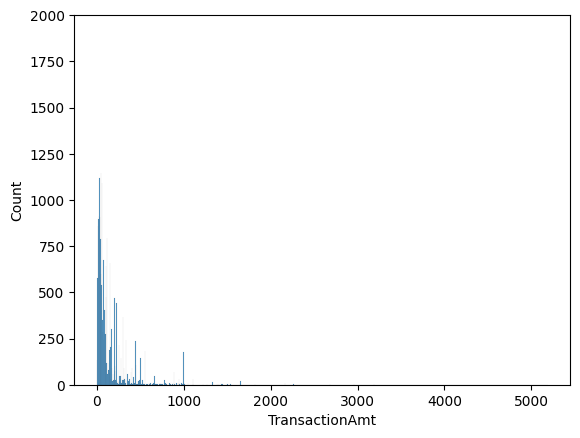

In [9]:
sns.histplot(data=df_trans_fraud, x='TransactionAmt', bins=1000)
plt.ylim(0, 2000)

(0.0, 5000.0)

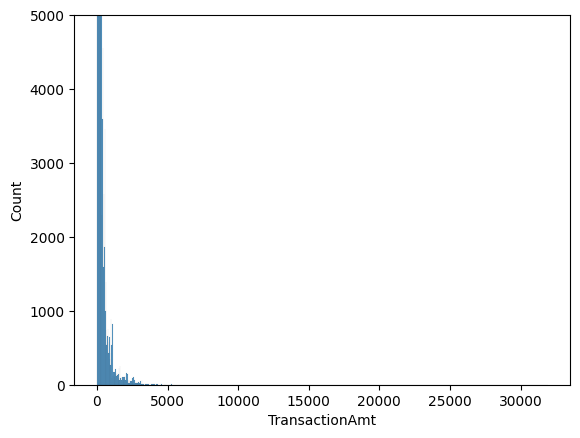

In [10]:
sns.histplot(data=df_trans_not_fraud, x='TransactionAmt', bins=1000)
plt.ylim(0, 5000)

most transactions are small

Now lets look at missing data

In [11]:
missing_data = []

In [12]:
for col in merged_transaction_df.columns:
    missing_fraction = merged_transaction_df[col].isna().sum() / len(merged_transaction_df)
    missing_data.append([col, missing_fraction])

In [13]:
missing_data_df = pd.DataFrame(missing_data, columns=['column', 'missing_fraction'])

Jeez lots of missing data!
Lets keep columns as long as they 50% or more of data in fraud and non fraud transactions

In [14]:
merged_transaction_df_cleaned = merged_transaction_df.copy()

In [15]:
threshold = 0.5  # for example, drop columns with >20% missing

In [16]:
for col in merged_transaction_df_cleaned.columns:
    missing_fraction_not_fraud = df_trans_not_fraud[col].isna().sum() / len(df_trans_not_fraud)
    missing_fraction_fraud = df_trans_fraud[col].isna().sum() / len(df_trans_fraud)
    if missing_fraction_not_fraud > threshold:
        merged_transaction_df_cleaned.drop(columns=col, inplace=True)
    elif missing_fraction_fraud > threshold:
        merged_transaction_df_cleaned.drop(columns=col, inplace=True)

this leaves us with 202 features 

now lets fill the nan
first lets find the categorical columns

In [17]:
cols = merged_transaction_df_cleaned.columns

In [18]:
num_cols = merged_transaction_df_cleaned._get_numeric_data().columns

In [19]:
cats = list(set(cols) - set(num_cols))

In [20]:
for col in cats:
    print(merged_transaction_df_cleaned[col].unique())

['W' 'H' 'C' 'S' 'R']
['discover' 'mastercard' 'visa' 'american express' nan]
[nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']
['M2' 'M0' nan 'M1']
['credit' 'debit' nan 'debit or credit' 'charge card']


These are categorical features we need to convert to numeric, below does this

In [21]:
for col in merged_transaction_df_cleaned.columns:
    unique_vals = set(merged_transaction_df_cleaned[col][merged_transaction_df_cleaned[col].notna()].unique())  # drop NaNs to avoid false negatives
    if set(unique_vals) <= {'credit', 'debit', 'charge card','debit or credit'}:
        merged_transaction_df_cleaned[col] = merged_transaction_df_cleaned[col].map({'credit': 1, 'debit': 0, 'charge card': 2, 'debit or credit':3})

In [22]:
for col in merged_transaction_df_cleaned.columns:
    unique_vals = set(merged_transaction_df_cleaned[col][merged_transaction_df_cleaned[col].notna()].unique())   # drop NaNs to avoid false negatives
    if set(unique_vals) <= {'visa', 'mastercard', 'discover','american express'}:
        merged_transaction_df_cleaned[col] = merged_transaction_df_cleaned[col].map({'visa': 1, 'mastercard': 0, 'discover': 2, 'american express': 3})

In [23]:
for col in merged_transaction_df_cleaned.columns:
    unique_vals = set(merged_transaction_df_cleaned[col][merged_transaction_df_cleaned[col].notna()].unique())   # drop NaNs to avoid false negatives
    if set(unique_vals) <= {'M0','M2','M1'}:
        merged_transaction_df_cleaned[col] = merged_transaction_df_cleaned[col].map({'M1': 1, 'M0': 0, 'M2': 2}) 

In [24]:
for col in merged_transaction_df_cleaned.columns:
    unique_vals = set(merged_transaction_df_cleaned[col][merged_transaction_df_cleaned[col].notna()].unique())   # drop NaNs to avoid false negatives
    if set(unique_vals) <= {'W', 'C', 'R', 'S', 'H'}:
        merged_transaction_df_cleaned[col] = merged_transaction_df_cleaned[col].map({'W': 1, 'C': 0, 'R': 2, 'S': 3, 'H': 4}) 

convert email domains

In [25]:
domains = merged_transaction_df_cleaned['P_emaildomain'].unique()

In [26]:
domains = domains[1:]

In [27]:
# Convert to a pandas Series
series = pd.Series(domains)

In [28]:
# Convert to numeric labels
encoded = series.astype("category").cat.codes

In [29]:
# If you want to see the mapping:
label_mapping = {label: code for code, label in enumerate(series.astype("category").cat.categories)}

In [30]:
merged_transaction_df_cleaned['P_emaildomain'] = merged_transaction_df_cleaned['P_emaildomain'].map(label_mapping)

#### look for colinear V columns

In [31]:
v_columns = [col for col in merged_transaction_df_cleaned.columns if col.startswith("V")]

In [32]:
just_Vs = merged_transaction_df_cleaned[v_columns]

In [33]:
V_corr = just_Vs.corr()

In [34]:
np.fill_diagonal(V_corr.values, 0)

<Axes: >

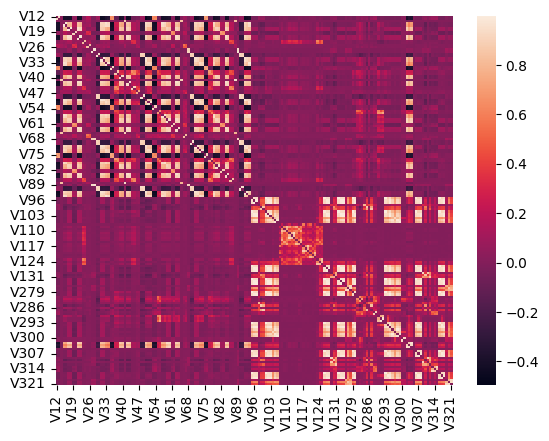

In [35]:
sns.heatmap(V_corr)

geez there is a lot 

lets filter high correlation out

first fill in diagnol (self correlation always 1)

In [36]:
# Compute correlation matrix
# Take absolute value 
V_corr = just_Vs.corr().abs()  

In [37]:
np.fill_diagonal(V_corr.values, 0)

In [38]:
# Create mask for upper triangle
upper = np.triu(np.ones(V_corr.shape), k=1).astype(bool)
upper_corr = V_corr.where(upper)

In [39]:
# Set your threshold
threshold = 0.6

In [40]:
# Find column pairs with correlation above the threshold
to_drop = set()

In [41]:
for col in upper_corr.columns:
    for row in upper_corr.index:
        if upper_corr.loc[row, col] > threshold:
            # Randomly drop one of the two
            drop_col = np.random.choice([row, col])
            to_drop.add(drop_col)

In [42]:
# Drop selected columns
reduced_df = merged_transaction_df_cleaned.drop(columns=to_drop)

After removing correlated features we have just 51 features!

we don't need to fill missing data as xgboost handles this

In [43]:
X = reduced_df.drop(columns = ['isFraud', 'TransactionID'])       # Features
y = reduced_df['isFraud']     # Labels

In [44]:
# 3. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [45]:
# create model instance
bst = XGBClassifier(scale_pos_weight=4, objective='binary:logistic', n_estimators=300, max_depth=15, learning_rate=0.2, gamma= 0.2,
                    colsample_bytree=0.8, subsample=1.0, reg_lambda=5)
# fit model
bst.fit(X_train, y_train)
# make predictions
test_predictions = bst.predict(X_test)
print("Best Accuracy:", accuracy_score(y_test, test_predictions))
print("Classification Report:\n", classification_report(y_test, test_predictions))

Best Accuracy: 0.9869723755658663
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    170821
           1       0.91      0.71      0.80      6341

    accuracy                           0.99    177162
   macro avg       0.95      0.85      0.89    177162
weighted avg       0.99      0.99      0.99    177162



In [46]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='error')

In [47]:
param_dist = {
    'scale_pos_weight': [2, 4, 6, 8],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.1, 0.2, 0.5, 0.7, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 1.0],
    'reg_lambda': [0, 1, 2, 5, 10],
}

In [48]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  # Increase for a more thorough search
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [49]:
random_search.fit(X_train, y_train.values.ravel()) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:11:54] WARN

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 5, 7, 10, 15],
                                        'n_estimators': [50, 100, 200, 300],
                                        'reg_lambda': [0, 1, 2, 5, 10],
                                        'scale_pos_weight': [2, 4, 6, 8],
                                        'subsample': [0.1, 0.2, 0.5, 0.7, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [50]:
best_model = random_search.best_estimator_
test_predictions = best_model.predict(X_test)
print("Best Accuracy:", accuracy_score(y_test, test_predictions))
print("Classification Report:\n", classification_report(y_test, test_predictions))
print(random_search.best_params_)
#{'subsample': 1.0, 'scale_pos_weight': 4, 'reg_lambda': 5, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}

Best Accuracy: 0.9869723755658663
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    170821
           1       0.91      0.71      0.80      6341

    accuracy                           0.99    177162
   macro avg       0.95      0.85      0.89    177162
weighted avg       0.99      0.99      0.99    177162

{'subsample': 1.0, 'scale_pos_weight': 4, 'reg_lambda': 5, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}


Best Accuracy: 0.9871642903105632
Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    170821
         1       0.91      0.71      0.80      6341

   accuracy                           0.99    177162
  macro avg       0.95      0.85      0.90    177162
weighted avg       0.99      0.99      0.99    177162

### look at ROC curve ######

No Skill: ROC AUC=0.500
xgboost: ROC AUC=0.967


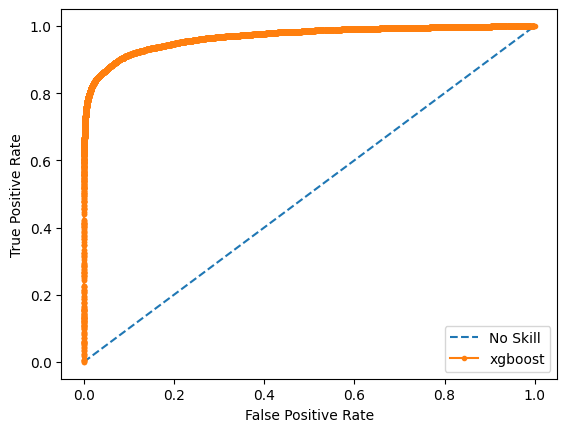

In [51]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
xgb_probs = bst.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('xgboost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='xgboost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
#xgboost: ROC AUC=0.968

xgb: f1=0.796 auc=0.838


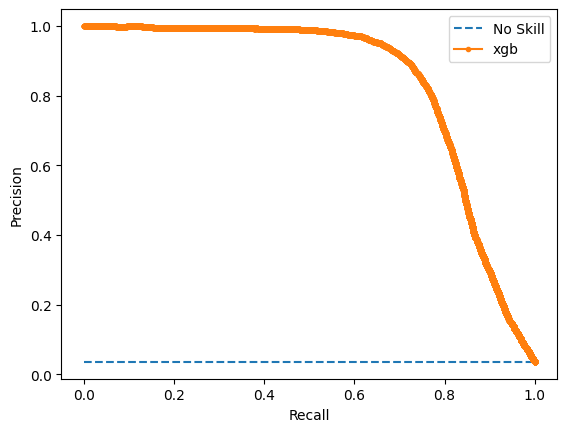

In [52]:
### look at PR curve #####
xgb_probs = bst.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# predict class values
yhat = bst.predict(X_test)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_f1, xgb_auc = f1_score(y_test, yhat), auc(xgb_recall, xgb_precision)
# summarize scores
print('xgb: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='xgb')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
#xgb: f1=0.798 auc=0.840

#### ok now lets try smotetomek links #####

smotetomek links doesn't tolerate missing data so we need to fill it in, for this we will do median values

In [53]:
reduced_smotek = reduced_df.copy()

In [54]:
for col in reduced_smotek.columns:
    median_value = reduced_smotek[col].median()
    reduced_smotek[col] = reduced_smotek[col].fillna(median_value)

In [55]:
#sanity check it's filled in 
reduced_smotek.columns[reduced_smotek.isna().any()].tolist()

[]

In [56]:
X_smotek = reduced_smotek.drop(columns = ['isFraud', 'TransactionID'])       # Features
y_smotek = reduced_smotek['isFraud']     # Labels

In [57]:
# 3. Split data into training and testing sets
X_train_smotek, X_test_smotek, y_train_smotek, y_test_smotek = train_test_split(X_smotek, y_smotek, test_size=0.3, random_state=42, shuffle=True)

In [58]:
# this will over sample minority by creating synthetic data k nearest neighbors and then use tomek links to clean up overlap between minority and majority classes in cluster space 
smotetomek = SMOTETomek(random_state=0, sampling_strategy='not majority', n_jobs=4)

In [59]:
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_smotek, y_train_smotek)

<Axes: xlabel='isFraud', ylabel='count'>

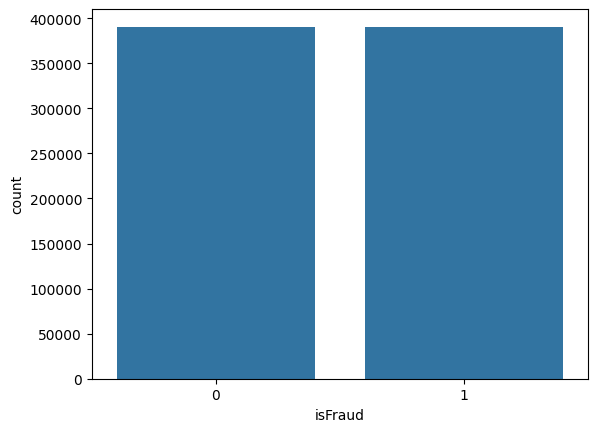

In [60]:
# Create a count plot
sns.countplot(x='isFraud', data=pd.DataFrame(y_train_smotetomek))

Text(0, 0.5, 'Count')

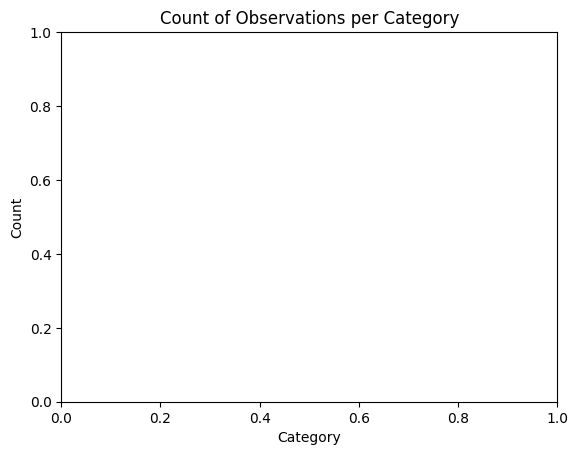

In [61]:
# Add title and labels (optional)
plt.title('Count of Observations per Category')
plt.xlabel('Category')
plt.ylabel('Count')

In [62]:
# Display the plot
plt.show()

now we have equal counts of fraud and non-fraud! cool!

In [63]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='error')

In [64]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.1, 0.2, 0.5, 0.7, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 1.0],
    'reg_lambda': [0, 1, 2, 5, 10],
}

In [65]:
random_search_smotetomek = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  # Increase for a more thorough search
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [66]:
random_search_smotetomek.fit(X_train_smotetomek, y_train_smotetomek.values.ravel()) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:22:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:22:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:22:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:22:30] WARN

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 5, 7, 10, 15],
                                        'n_estimators': [50, 100, 200, 300],
                                        'reg_lambda': [0, 1, 2, 5, 10],
                                        'subsample': [0.1, 0.2, 0.5, 0.7, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [67]:
best_model_smotetomek = random_search_smotetomek.best_estimator_
test_predictions_smotetomek = best_model_smotetomek.predict(X_test_smotek)
print("Best Accuracy:", accuracy_score(y_test_smotek, test_predictions_smotetomek))
print("Classification Report:\n", classification_report(y_test_smotek, test_predictions_smotetomek))
print(random_search_smotetomek.best_params_)
#{'subsample': 0.5, 'reg_lambda': 2, 'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

Best Accuracy: 0.9861200483173592
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    170821
           1       0.94      0.66      0.77      6341

    accuracy                           0.99    177162
   macro avg       0.96      0.83      0.88    177162
weighted avg       0.99      0.99      0.98    177162

{'subsample': 1.0, 'reg_lambda': 2, 'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}


Best Accuracy: 0.9860636028042131
Classification Report:
              precision    recall  f1-score   support

          0       0.99      1.00      0.99    170821
          1       0.93      0.66      0.77      6341

   accuracy                           0.99    177162
  macro avg       0.96      0.83      0.88    177162
weighted avg       0.99      0.99      0.98    177162

### look at ROC curve ######

No Skill: ROC AUC=0.500
xgboost: ROC AUC=0.968


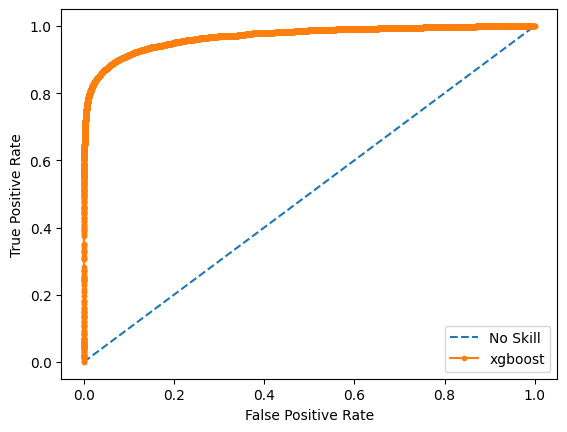

In [68]:
ns_probs = [0 for _ in range(len(y_test_smotek))]
# predict probabilities
xgb_probs = best_model_smotetomek.predict_proba(X_test_smotek)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test_smotek, ns_probs)
xgb_auc = roc_auc_score(y_test_smotek, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('xgboost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_smotek, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_smotek, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='xgboost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

xgboost: ROC AUC=0.962

xgb: f1=0.772 auc=0.835


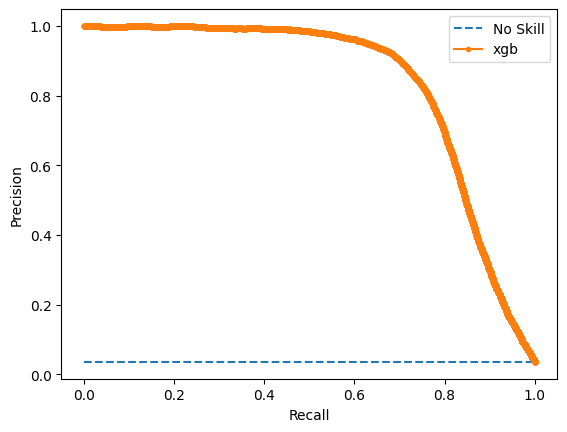

In [69]:
### look at PR curve #####
xgb_probs = best_model_smotetomek.predict_proba(X_test_smotek)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# predict class values
yhat = best_model_smotetomek.predict(X_test_smotek)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test_smotek, xgb_probs)
xgb_f1, xgb_auc = f1_score(y_test_smotek, yhat), auc(xgb_recall, xgb_precision)
# summarize scores
print('xgb: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
# plot the precision-recall curves
no_skill = len(y_test_smotek[y_test_smotek==1]) / len(y_test_smotek)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='xgb')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
#xgb: f1=0.773 auc=0.827

Cool! fun to try but looks like this model is slightly worse